In [202]:
import gensim
from gensim.parsing.preprocessing import preprocess_string

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pickle
import json
import glob
import collections


In [206]:
def plotTopicProjections(model,dictionary,scale=False,plotNegative=False,nTerms=5):
    '''
    Convenience function to plot term importances in topics
    @plotNegative is for models that return -ve term importances
    @scale is either fixed at [-1,1] or autoscaled based on largest importance
    @model is LDA/LSI gensim model object
    (C) Alex Rutherford
    '''
    
    topicProjections=model.get_topics()
    
    for n in range(topicProjections.shape[0]):
        #print(i)
        topicTerm=collections.Counter({dictionary[j]:p for j,p in\
                                       enumerate(topicProjections[n,:])})

        most = topicTerm.most_common(nTerms)[::-1]
        least = topicTerm.most_common()[-1*nTerms:]
        
        if not scale:
            plt.xlim(-1,1)
            maxExtent=1
        else:
            maxMost=max([m[1] for m in most])*1.1
            minLeast=min([l[1] for l in least])*1.1
            
            maxMost=topicProjections.max()*1.1
            minMost=topicProjections.min()*1.1
            
            maxExtent=max([abs(minLeast),abs(maxMost)])
            plt.xlim(-1*maxExtent,maxExtent)
                    
        plt.barh(range(nTerms),[m[1] for m in most], alpha=.5)
        for i,m in enumerate(most):
            plt.annotate('{:s} ({:.3f})'.format(m[0],m[1]),\
                         xy=(0.1*maxExtent,i-0.1),xycoords='data',fontsize=18, alpha=.8)
        
        if not plotNegative:
            if not scale:
                plt.xlim(0,1)
            else:
                plt.xlim(0,maxExtent)
        
        plt.barh(range(nTerms),[l[1] for l in least])
        for i,l in enumerate(least):
            plt.annotate('{:s} ({:.3f})'.format(l[0],l[1]),\
                         xy=(-0.1*maxExtent,i-0.1),xycoords='data',ha='right',fontsize=18,
                        alpha=.6)
        plt.axvline(color='grey')
        plt.title('Topic {:d}'.format(n))
        plt.yticks([],[])
        plt.xlabel('Projection')
        plt.show()

# Build a Gensim model

## Read in the data

In [5]:
path = r'C:\Users\aleksander.molak\Documents\EDU\9781789139938_Code\data\news_webhose'

In [207]:
# Test the preprocessing function
preprocess_string("""Can you preprocess this little string for me, my dear Gensim? 
                    That'd be nice! Thanks, mordo sheli!""")

['preprocess',
 'littl',
 'string',
 'dear',
 'gensim',
 'nice',
 'thank',
 'mordo',
 'sheli']

## Define Text Generator

In [227]:
class TextGen():
    
    """
    Object to iterate over text out of memory
    Generator: Yields tokenized documents one at a time
    `n` is number of lines to read, -1 == all lines
    `start` is line number to start from
    (useful for defining holdout)
    """
    
    def __init__(self, n=-1, start=0):
        print('Initializing textgenerator...')
        self.n = n
        self.start = start
        
    def __iter__(self):
        print('Doing..')
        for n_file, file in enumerate(glob.glob(path + r'\*\blogs*json')):
            if n_file % 50 == 0:
                print(f'{(n_file/holdout)*100:.1f}%', end='\r')
            if self.n > -1 and n_file > self.n:
                break
                
            with open(file, 'r', encoding='utf-8') as f:
                for line in f:
                    if len(line) > 0 and n_file >= self.start:
                        d = json.loads(line)
                        yield preprocess_string(d['text'])

## Define a test set to hold out and evaluate our topic models

In [228]:
holdout = 45000

In [229]:
text_dict = gensim.corpora.Dictionary(TextGen(n=holdout))

Initializing textgenerator...
Doing..


In [230]:
# Drop terms that appear less than 5 times and in more than 50% of docs
# Then filter to top 100k terms
text_dict.filter_extremes()

In [231]:
# Write out text_dict
with open('text_dict.pkl', 'wb') as outfile:
    pickle.dump(text_dict, outfile)

In [232]:
# Read in the dict
with open('text_dict.pkl', 'rb') as infile:
    text_dict = pickle.load(infile)

## Define corpus object

In [233]:
class NewsCorpus():
    """
    Class wrapper for reading news data
    Generator: yields indexed documents one at a time
    `n` is number of lines to read, -1 means all lines
    'start' is line number to start returning data
    """
    
    def __init__(self, n=-1, start=0):
        print('Initializing corpus...')
        self.n = n
        self.start = start
        
    def __iter__(self):
        for n_file, file in enumerate(glob.glob(path + r'\*\blogs*json')):
            if n_file % 50 == 0:
                print(f'{(n_file/self.n)*100:05.1f}%', end='\r')
            if self.n > -1 and n_file > self.n:
                break
                
            with open(file, 'r', encoding='utf-8') as infile:
                for line in infile:
                    
                    if len(line) > 0 and n_file >= self.start:
                        d = json.loads(line)
                        tokens = preprocess_string(d['text'])
                        
                        yield text_dict.doc2bow(tokens)

## LDA

### Train LDA on test set with 4 topics

In [234]:
res_lda = gensim.models.ldamulticore.LdaMulticore(NewsCorpus(n=holdout),
                               num_topics = 2, id2word = text_dict) 

Initializing corpus...


In [236]:
# # 10-topic version
# res_lda_10 = gensim.models.ldamulticore.LdaMulticore(NewsCorpus(n=holdout),
#                                num_topics = 10, id2word = text_dict) 

### Plot topics

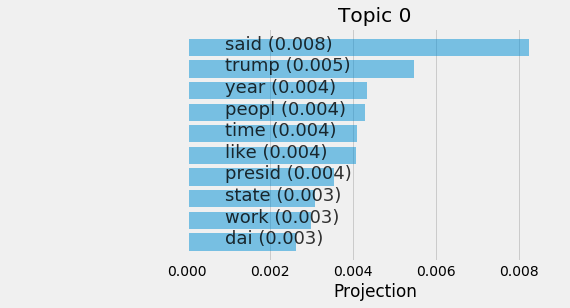

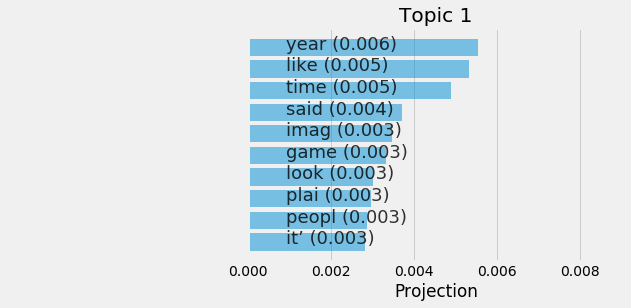

In [237]:
plotTopicProjections(res_lda, text_dict, scale=True, nTerms=10)

### Check how classification works

In [241]:
res_lda.get_document_topics(text_dict.doc2bow(\
preprocess_string('Imagination of young people is amazing! Changes in look of modern')))

[(0, 0.09834861), (1, 0.9016514)]

## TF-IDF scaling

In [243]:
tfidf = gensim.models.TfidfModel(dictionary=text_dict)

## LDA using TF-IDF

In [244]:
res_tfidf = gensim.models.ldamulticore.LdaMulticore(\
            tfidf[NewsCorpus(n=holdout)], num_topics=2, id2word=text_dict)

Initializing corpus...


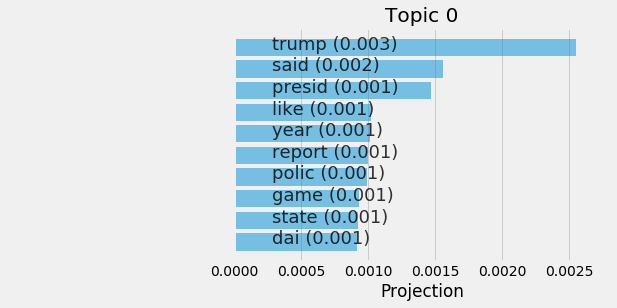

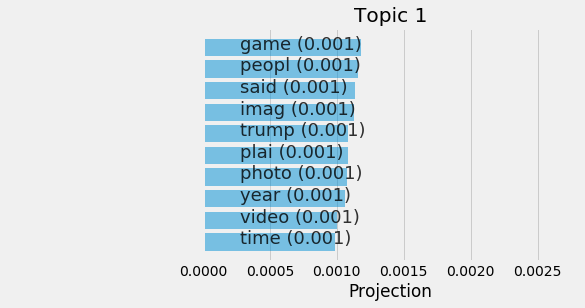

In [245]:
plotTopicProjections(res_tfidf, text_dict, scale=True, nTerms=10)

## LSI Model

In [248]:
res_lsi = gensim.models.lsimodel.LsiModel(\
                        NewsCorpus(n=holdout), num_topics=2, id2word=text_dict)

Initializing corpus...


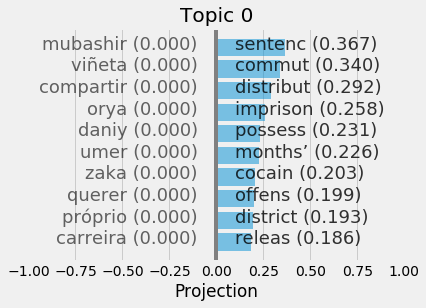

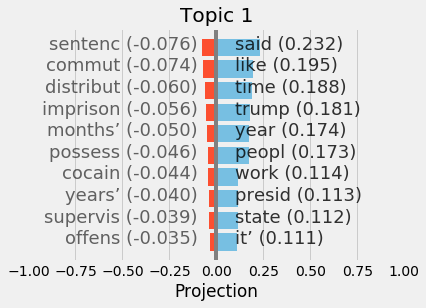

In [249]:
plotTopicProjections(res_lsi, text_dict, plotNegative=True, nTerms=10)